## Strategy
#### Step1) Data preprocessing
- It normalizes the dataset first

#### Step2) Dataset understanding
- By analysing, we understand the dataset

#### Step3) Build RNN model to predict target sensor(Y18)
- Predict past values a part of train dataset
- Predict future(test set) values by using whole train dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Data preprocessing
- It has two dataset(train, test) 
- Weather is input and Sensors is output
- Ploting, some sensors show similar time series shapes. 

In [2]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
train, test = train.drop('id', axis=1), test.drop('id', axis=1)

weather_col = train.columns[0:40].to_list()
sensor_col = train.columns[40:].to_list()

- min-max normalization

In [3]:
train[weather_col] = (train[weather_col]-train[weather_col].min()) / (train[weather_col].max()-train[weather_col].min())
train[sensor_col[:-1]]=(train[sensor_col[:-1]]-train[sensor_col[:-1]].min()) / (train[sensor_col[:-1]].max()-train[sensor_col[:-1]].min())
test = (test-test.min()) / (test.max()-test.min())

## Data understanding
- For each sensor, it selects feature by using Pearon's coefficient matirx and filters features which is bigger than 0.7

In [4]:
corr = train.loc[train['Y18'].isnull()].corr().abs()

In [5]:
var_set = []
for i in range(0, 18):
    _var = corr[sensor_col].loc[weather_col].iloc[:,i].loc[corr[sensor_col].loc[weather_col].iloc[:,i]>0.7].index.tolist()
    var_set.append(_var)
    
var_set

[['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X34', 'X37'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37', 'X38'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37', 'X38'],
 ['X00', 'X07', 'X11', 'X28', 'X31', 'X32', 'X34'],
 ['X00', 'X07', 'X11', 'X28', 'X31', 'X32', 'X34'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32'],
 ['X00', 'X12', 'X30', 'X31', 'X32'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', 'X37'],
 ['X00', 'X07', 'X12', 'X20', 'X28', 'X30', 'X31', 'X32', '

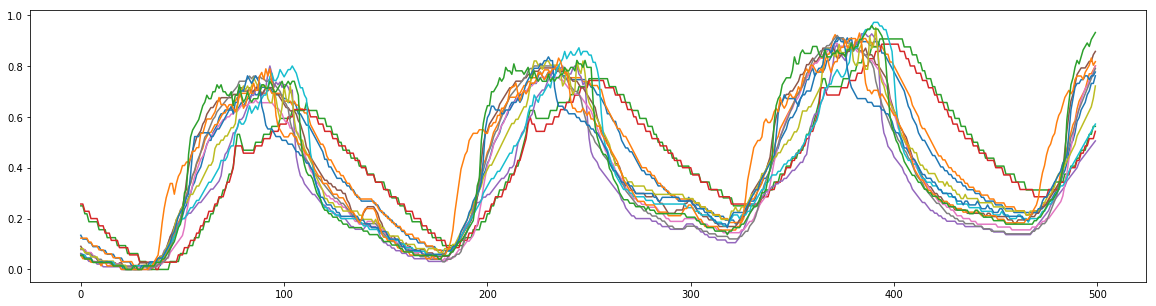

In [6]:
graph = train.loc[train['Y18'].isnull()].iloc[:, 40:59][['Y01', 'Y02', 'Y03', 'Y04', 'Y08', 'Y09', 'Y10', 'Y11', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']]
plt.figure(figsize=(20,5))
plt.plot(graph.iloc[0:500])
plt.show()

Here, we can interpret that Y01 and Y02, Y03 and Y04, Y08 to Y11, Y13 to 17 are in similar environment

## Build RNN model
1)  Build RNN model for Y18
- input dim = 42 
- output dim = 1 
- sequence length = 10 

2) Predict past temperatures of Y18

3) Predict future temperatrues for test dataset

In [7]:
Y18 = train.loc[train['Y18'].notnull()]
Y18 = pd.concat([Y18[weather_col], Y18['Y18']], axis=1)
Y18['Y18'] = (Y18['Y18'] - Y18['Y18'].min()) / (Y18['Y18'].max()-Y18['Y18'].min())
Y18 = Y18.sort_index(ascending=False).to_numpy()

x = Y18
y = Y18[:,[-1]]

dataX = []
dataY = []
seq_length = 10
input_dim = x.shape[1]
hidden_dim = 5
output_dim = 1

for i in range(0, len(x)-seq_length):
    _x = x[i:i+seq_length]
    _y = y[i+seq_length]
    
    dataX.append(_x)
    dataY.append(_y)
    
dataX = np.nan_to_num(dataX)

In [8]:
X = tf.placeholder (tf.float32, [None, seq_length, input_dim])
Y = tf.placeholder(tf.float32, [None, output_dim])

In [ ]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
loss = tf.reduce_sum(tf.square(Y_pred-Y))
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

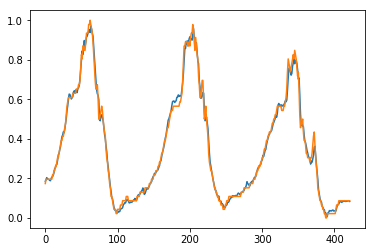

In [11]:
for i in range(1000):
    l, _ = sess.run([loss, optimizer], feed_dict={X: dataX, Y: dataY})
    
res = sess.run(Y_pred, feed_dict={X: dataX})

plt.plot(res)
plt.plot(dataY)
plt.show()

Our training set has partial temperature observations on Y18. 
Here, it predicts past observations 

In [12]:
updateX = np.vstack((np.nan_to_num(Y18[431]), dataX[421][1:]))
updateX = updateX.reshape(-1, 10, 41)
updateX = np.vstack((dataX, updateX))
updateRes = sess.run(Y_pred, feed_dict={X: updateX})

In [14]:
for i in range(4319, -1, -1):
    idx = len(updateRes)-1
    
    _x = np.nan_to_num(train.sort_index(ascending=False).loc[i][weather_col].to_numpy())
    _y = updateRes[idx]
    _xy = np.hstack((_x, _y))
    
    _update = updateX[idx][1:] 
    _update = np.vstack((_update, _xy)).reshape(-1, 10, 41)
    
    updateX = np.vstack((updateX, _update))
    updateRes = sess.run(Y_pred, feed_dict={X: updateX})

Orange line is observed temperature in training set and blue line is predicted past temperatures by RNN model 
We will save predicted past temperatures as training dataset to apply RNN model to test dataset

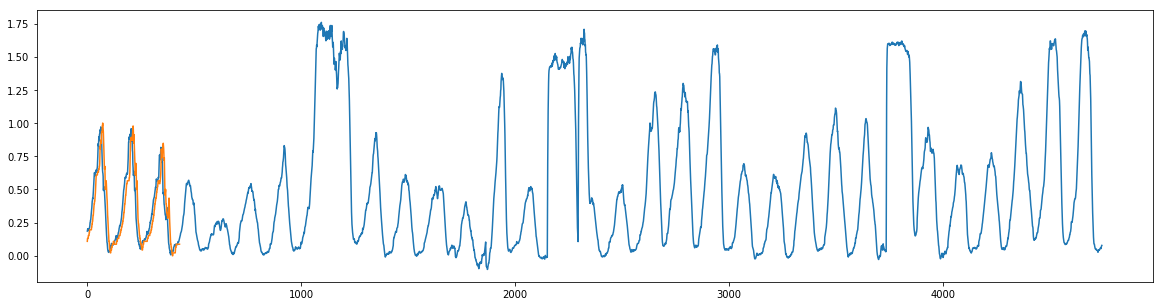

In [15]:
plt.figure(figsize=(20,5))
plt.plot(updateRes)
plt.plot(Y18[:,40])
plt.show()

Above implementation, we predict missing past observations. 
To predict temperater for testing dataset, we use pre-observed data and predicted data in training dataset

In [16]:
Y18_train = pd.concat((train[weather_col], train['Y18']), axis=1)
Y18_min = Y18_train['Y18'].min()
Y18_max = Y18_train['Y18'].max()
Y18_train['Y18'] = (Y18_train['Y18'] - Y18_min) / (Y18_max - Y18_min)
Y18_train['Y18'][0:4320]=updateRes[423:][::-1].reshape(4320)

test['Y18'] = 0
full = pd.concat((Y18_train,test), axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [17]:
x = np.nan_to_num(full.to_numpy())[0:4751]
y = x[:,[-1]]

trainX = []
trainY = []

for i in range(0, len(x)-seq_length):
    _x = x[i:i+seq_length]
    _y = y[i+seq_length]
    
    trainX.append(_x)
    trainY.append(_y)

In [18]:
for i in range(1000):
    l, _ = sess.run([loss, optimizer], feed_dict={X: trainX, Y: trainY})
    
res = sess.run(Y_pred, feed_dict={X: trainX})

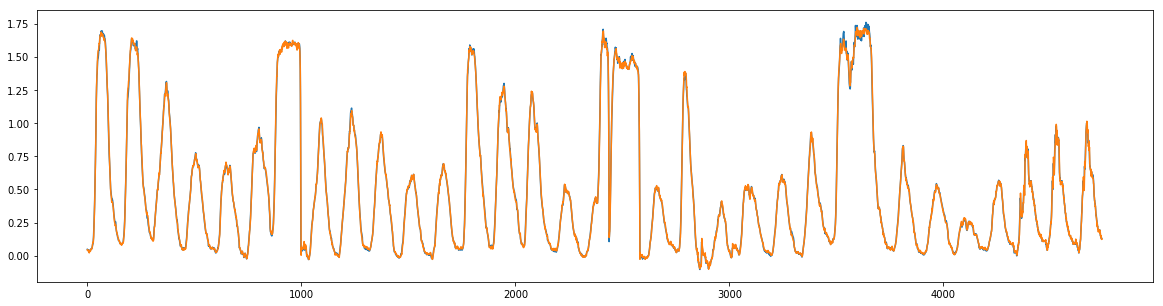

In [19]:
plt.figure(figsize=(20,5))
plt.plot(trainY)
plt.plot(res)
plt.show()

In [20]:
for i in range(4742, len(full)): 
    idx = len(res) - 1
    _x = np.nan_to_num(full.to_numpy())[i][:-1]
    _y = res[idx]
    _xy = np.hstack((_x, _y))
    
    
    _update = trainX[idx][1:]
    _update = np.vstack((_update, _xy)).reshape(-1, 10, 41)
    
    trainX = np.vstack((trainX, _update))
    res = sess.run(Y_pred, feed_dict={X: trainX})

Predicted temperature results 

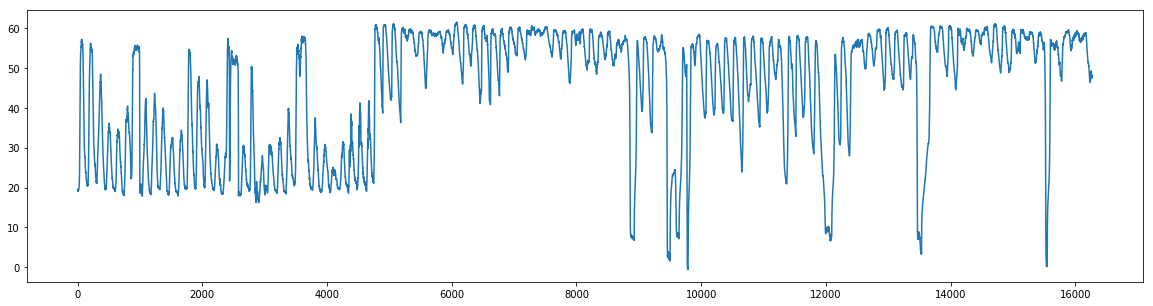

In [24]:
plt_res = (res * (Y18_max - Y18_min)) + Y18_min
plt.figure(figsize=(20,5))
plt.plot(plt_res)
plt.show()